In [1]:
# !nvidia-smi

In [2]:
"""
Resnet-18 for classifying roof materials from PlanetScope SuperDove imagery
Case study in Washington, D.C. 
"""

import os, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import gc
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from fiona.crs import from_epsg
from shapely.geometry import box

import warnings
warnings.filterwarnings("ignore")

plt.ion() # interactive

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Successfully imported all packages!")

Projected CRS: EPSG:32618
Successfully imported all packages!


In [3]:
class RoofImageDataset_Planet(Dataset):
    """Class to handle PlanetScope SuperDove imagery for Resnet-18"""

    def __init__(self, gdf, img_path, n_bands, img_dim, transform=None):
        """
        Args:
            gdf: Geodataframe containing 'geometry' column and 'class_code' column
            img_path: the path to the PlanetScope SuperDove composite image (single mosaic file)
                - see 'psscene-prep.py' for spectral indices calculation
            imgdim (int): Image dimension for CNN implementation
            transform (callable, optional): Optional transform to be applied on a sample

        Returns image chunks with class labels
        """

        if not os.path.exists(img_path):
            raise ValueError(f'Image does not exists: {img_path}')

        self.geometries = [p.centroid for p in gdf.geometry.values] # gather centroid geoms
        self.img_path = img_path # path to image data
        self.img_dim = img_dim # resnet window dimension, defaults to 64
        self.n_bands = n_bands # number of bands in the input image
        self.Y = gdf.code.values # class codes (numeric)
        self.transform = transform
        
    def __len__(self):
        return len(self.geometries)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the geometry of the idx (centroid)
        geom = self.geometries[idx]

        try:
            sample = self.sample_image(geom)  # run the sampling function
        
            cc = self.Y[idx]  # get the class codes
            if type(cc) != int:
                cc = cc.astype('uint8') # make sure the cc is an integer
            
            # Ensure the sample has the correct dimensions
            assert sample.shape == (self.n_bands, self.img_dim, self.img_dim), f'Invalid sample shape: {sample.shape}'

            if self.transform:
                sample = self.transform(sample)
                        
        except Exception as e:
            raise ValueError(e)
            print(f"Skipping invalid sample at index: {idx}")
            sample = torch.from_numpy(np.zeros((self.n_bands, int(self.img_dim), int(self.img_dim))))
            cc = 255 # highest int8 number to be flagged
         
        # Convert the sample array to a Torch object
        sample = torch.from_numpy(sample)

        # Return the sample and the label as torch objects
        return {'image': sample.type(torch.FloatTensor),
                'code': torch.tensor(cc).type(torch.LongTensor)}

    
    def sample_image(self, geom):
        """ Sample the image at each geometry for the specified image chunk size (window) """
 
        N = self.img_dim # window size to be used for cropping
            
        # Use the windows.from_bounds() method to return the window
        # Returns image chunks from training data locations
        with rio.open(self.img_path) as src:
            py, px = src.index(geom.x, geom.y)
            window = rio.windows.Window(px - N // 2, py - N // 2, N, N)
            # print(window)
            
            # Read the data in the window
            # clip is a nbands * N * N numpy array
            clip = src.read(window=window, indexes=list(range(1, self.n_bands + 1)))

            del py, px, window # clean up

        # Convert the image chunk to a numpy array
        clip_arr = np.array(clip)

        # Check if the image chunk has valid data
        if clip_arr.sum() > 0:
            # Mask invalid values in each band independently
            ans = np.ma.masked_equal(clip_arr, 0).filled(0)
        else:
            ans = clip_arr
        
        del clip, clip_arr # clean up
        return ans


def make_good_batch(batch):
    """
    Removes bad samples if image dimensions do not match.
    Args:
        - batch: list of dictionaries, each containing 'image' tensor and 'code' tensor
    returns: list of dictionaries same as input with samples having non-matching image dims removed
    """

    _idx = torch.where(batch['code'] != 255)[0] # good batches

    new_batch = {}
    new_batch['image'] = batch['image'][_idx]
    new_batch['code'] = batch['code'][_idx]

    return new_batch


def balance_sampling(df, ratio=5, strategy='undersample'):
    """
    Generate balanced sample from training data based on the defined ratio.
    This can be done with majority undersampling or minority oversampling ('strategy' parameter)
    Args:
        - df: the dataframe with rows as training data
        - ratio: the sampling ration (i.e., 5:1 for minority classes default)
    Returns:
        - random sample with class ratios as defined
    """
    
    # Get the class counts
    class_counts = df['class_code'].value_counts()
    min_class_count = class_counts.min()
    
    # Calculate the target count for each class based on the ratio
    target_count = {
        class_label: max(min_class_count, min(min_class_count * ratio, len(df[df['class_code'] == class_label]))) 
        for class_label in class_counts.index
    }
    
    # Create an empty list to store balanced dataframes
    balanced_dfs = []
    for class_label in class_counts.index:
        class_df = df[df['class_code'] == class_label]
        if strategy == 'undersample':
            # Under-sample the majority class, but do not undersample below its original count
            balanced_class_df = resample(
                class_df, replace=False, n_samples=target_count[class_label], random_state=42)
        elif strategy == 'oversample':
            # Over-sample the minority class
            balanced_class_df = resample(
                class_df, replace=True, n_samples=target_count[class_label], random_state=42)
        balanced_dfs.append(balanced_class_df)

    # Concatenate the results by class
    balanced_df = pd.concat(balanced_dfs)
    return balanced_df


def split_training_data(gdf, ts, vs):
    """ 
    Splits dataframe into train, test, and validation samples with the defined ratios 
    Args:
        - gdf: training samples (geo data frame)
        - ts: test size #
        - vs: validation size #
    Returns:
        train, test, and validation dataframes
    """
    
    train_df, test_df, val_df = [], [], []

    for cl in gdf.class_code.unique():
        
        # subset to class
        _gdf = gdf.loc[gdf.class_code == cl]
        
        # get train and test validation arrays. 
        # test array is validation array split in half.
        _train, _valtest = train_test_split(_gdf, random_state=27, test_size=ts)
        train_df.append(_train)
        
        _val, _test = train_test_split(_valtest, random_state=27, test_size=vs)
        test_df.append(_test)
        val_df.append(_val)

    # Concatenate the samples across classes
    all_train_df = pd.concat(train_df)
    all_train_df = gpd.GeoDataFrame(all_train_df, crs=gdf.crs)
    
    all_val_df = pd.concat(val_df)
    all_val_df = gpd.GeoDataFrame(all_val_df, crs=gdf.crs)
    
    all_test_df = pd.concat(test_df)
    all_test_df = gpd.GeoDataFrame(all_test_df, crs=gdf.crs)

    return all_train_df, all_val_df, all_test_df


print("Class and functions ready to use!")

Class and functions ready to use!


In [4]:
os.chdir('/home/jovyan')
print(os.getcwd())

/home/jovyan


In [5]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
gdf_path = 'opp-data/dc_data_reference_footprints.gpkg'
footprints = gpd.read_file(gdf_path)
footprints.head()

,class_code,areaUTMsqft,uid,description,code,geometry
0,CS,357.783709,1CS,Composition Shingle,0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,CS,918.640862,2CS,Composition Shingle,0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,CS,1383.414170,3CS,Composition Shingle,0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,CS,836.410297,4CS,Composition Shingle,0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,CS,330.514264,5CS,Composition Shingle,0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [6]:
# Calculate the 'optimal' window size from the footprint areas (meters)
mean_area_sqm = int(footprints.areaUTMsqft.values.mean()) * 0.092903
pct90_area_sqm = np.percentile(footprints.areaUTMsqft, 90) * 0.092903
print(f'Mean footprint area (sqm): {mean_area_sqm}')
print(f'90th percentile footprint area (sqm): {pct90_area_sqm}')
# Calculate the side length ('optimal' window size) * 3 
print(f'90th percentile side length (m): {int(np.sqrt(pct90_area_sqm))}')

# Calculate the mean across different class codes
class_code_means = footprints.groupby('class_code')['areaUTMsqft'].mean() * 0.092903
print(f'\nMean footprint area by class_code (sqm):\n {class_code_means}')

Mean footprint area (sqm): 99.499113
90th percentile footprint area (sqm): 158.13312473978425
90th percentile side length (m): 12

Mean footprint area by class_code (sqm):
 class_code
CS    106.067916
ME     83.614598
SH    115.680340
SL    122.038118
TL    150.720654
UR     80.790722
WS    124.480158
Name: areaUTMsqft, dtype: float64


In [7]:
# Observe the class imbalance
footprints.class_code.value_counts()

class_code
ME    29651
CS    27687
SL    11080
UR     1018
WS      866
TL      617
SH      589
Name: count, dtype: int64

In [8]:
# # Combine SH and WS
# ref = footprints
# # Merge the shingle classes (wood shingle and shingle)
# merge = {'WS': 'WSH', 'SH': 'WSH'}
# ref['class_code'].replace(merge, inplace=True)
# print(ref['class_code'].value_counts())  # check the counts
# del footprints
# gc.collect()

In [9]:
ref = footprints
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(ref['class_code'], ref['code']))
print(class_mapping)

{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}


In [10]:
# Identify 'good' training locations

In [10]:
print(ref.crs)

EPSG:32618


In [11]:
# Create centroids
ref_pt = ref.copy()
ref_pt = ref_pt.to_crs(epsg=32618)
ref_pt['geometry'] = ref_pt['geometry'].centroid

# Define the window size and half window (for boxes)
window_size = 52 # 4 * average side length (relative neighbors (?))
half_window = window_size / 2

training_windows = [] # image windows with >50% of specific roof type
training_roof_types = [] # roof type codes for valid windows

# Loop through each footprint individually
for geom, roof_type in zip(ref.geometry, ref['class_code']):
    # calculate the image window as footprint buffer
    centroid = geom.centroid
    window = box(centroid.x - half_window, centroid.y - half_window,
                 centroid.x + half_window, centroid.y + half_window)

    # Intersect with centroids to get class count within window
    intersect = ref_pt[ref_pt.intersects(window)]
    
    # Get the total count and count for the class
    total_count = len(intersect)
    class_count = len(intersect[intersect['class_code'] == roof_type])

    # Check if there is at least 50% of the roof type in that window
    if total_count > 0 and (class_count / total_count) > 0.50:
        training_windows.append(geom)
        training_roof_types.append(roof_type)

    del intersect, window, centroid

# Create a GeoDataFrame for the training windows with roof types
ref_windows = gpd.GeoDataFrame({
    'geometry': training_windows, 
    'class_code': training_roof_types
}, crs=ref.crs)

# Create a numeric code for the training data frame
ref_windows['code'], _ = pd.factorize(ref_windows['class_code'])
print("Spatial filtering complete.")

Spatial filtering complete.


In [13]:
# Save out
os.getcwd()
out_file = os.path.join(maindir,'data/spatial/mod/dc_data/rooftop_materials_training_windows.gpkg')
ref_windows.to_file(out_file)

del training_windows, training_roof_types, ref_pt
gc.collect()

0

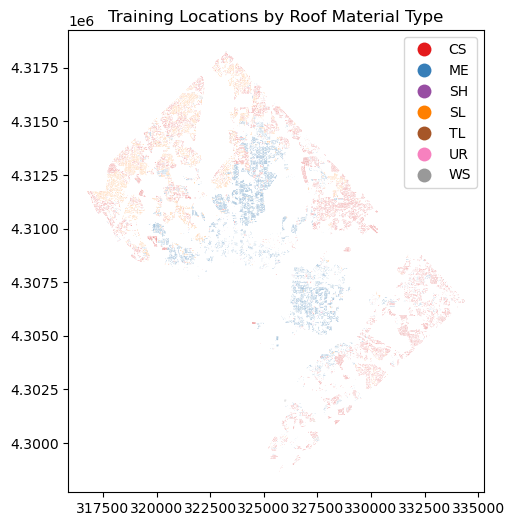

In [12]:
# Plot the training locations with colors based on roof type
fig, ax = plt.subplots(figsize=(6, 6))
ref_windows.plot(column='class_code', ax=ax, legend=True, cmap='Set1', edgecolor='none')
plt.title('Training Locations by Roof Material Type')
plt.show()

In [13]:
ref_windows.class_code.value_counts()

class_code
ME    28557
CS    24698
SL     8619
WS      362
UR      286
TL      260
SH      175
Name: count, dtype: int64

In [14]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref_windows, ratio=10, strategy='undersample')
ref_bal.class_code.value_counts()

class_code
ME    1750
CS    1750
SL    1750
WS     362
UR     286
TL     260
SH     175
Name: count, dtype: int64

In [15]:
# Split the train/test data
train_df, val_df, test_df = split_training_data(ref_bal, ts=0.4, vs=0.2)

# Print the class distribution in training and validation sets to verify stratification
print("Train class distribution:\n", train_df['code'].value_counts())
print("Validation class distribution:\n", val_df['code'].value_counts())
print("Test class distribution:\n", test_df['code'].value_counts())

Train class distribution:
 code
1    1050
0    1050
2    1050
5     217
3     171
4     156
6     105
Name: count, dtype: int64
Validation class distribution:
 code
1    560
0    560
2    560
5    116
3     92
4     83
6     56
Name: count, dtype: int64
Test class distribution:
 code
1    140
0    140
2    140
5     29
3     23
4     21
6     14
Name: count, dtype: int64


In [18]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join('opp-data/dc_0623_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0] # get a list of band names
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (8223, 6714)
bands: 6
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Array: <xarray.DataArray (band: 6, y: 8223, x: 6714)> Size: 1GB
[331255332 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [31]:
# Best params from tuning
params = {'window_size': 104, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 2e-4, 'momentum': 0.9, 'patience': 3}
print(f'Model parameters: {params}')

Model parameters: {'window_size': 104, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9, 'patience': 3}


In [32]:
# Set up the Resnet-18 model

# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model dev ...')

# Grab the number of classes
n_classes = ref_bal.class_code.unique().shape[0]
print(f'There are {n_classes} roof type classes.')

# Define the Resnet-18 model (in_channels = number of bands in the image)
model = resnet18(n_classes, in_channels=n_bands, pretrained=False)

# Make model parallel and on GPU
if torch.cuda.device_count() >= 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)
else:
    #ps_model = nn.DataParallel(ps_model)
    model = nn.DataParallel(model)
    print('Made cpu parallel')

# optimizer, learning rate scheduler, loss criterion
optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'], weight_decay=params['weight_decay']).to(device)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=params['patience'], verbose=False, min_lr=1e-6).to(device)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
print('Ready to load data !')

Using cuda for model dev ...
There are 7 roof type classes.
Using  1 GPUs!
Ready to load data!


In [33]:
# Load the image data as a Dataset
# Uses the opimum window size calculated earlier

imdir = stack_da_fp
bs = params['batch_size']
window_size = params['window_size']

pin_memory=False
if device == "cuda":
    pin_memory=True # for GPU make true

# Create the training samples
train_ds = RoofImageDataset_Planet(
    train_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=pin_memory) 

# Create the validation samples
val_ds = RoofImageDataset_Planet(
    val_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
val_loader = DataLoader(val_ds, batch_size=bs, shuffle=True, pin_memory=pin_memory)

# Create the test samples
test_ds = RoofImageDataset_Planet(
    test_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=True, pin_memory=pin_memory)

print("Training and validation data loaded!")

Training and validation data loaded!


In [34]:
# Number of samples in each class
val_counts = list(train_df['code'].value_counts())
total_samples = sum(val_counts) # total number of samples
print(f'Total samples: {total_samples};\nValue counts: {val_counts}')

# Calculate class weights
class_weights = [total_samples / count for count in val_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")

class_weights_norm = class_weights / class_weights.sum()
print(f"Normalized class weights: {class_weights_norm}")

# Updated loss function with weights
criterion = nn.CrossEntropyLoss(weight=class_weights_norm).to(device)

Total samples: 3799;
Value counts: [1050, 1050, 1050, 217, 171, 156, 105]
Class weights: tensor([ 3.6181,  3.6181,  3.6181, 17.5069, 22.2164, 24.3526, 36.1810],
       device='cuda:0')
Normalized class weights: tensor([0.0326, 0.0326, 0.0326, 0.1576, 0.1999, 0.2192, 0.3256],
       device='cuda:0')


In [35]:
gc.collect()

0

In [36]:
t0 = time.time()

print_freq = int(len(train_loader) // 4) # quarterly print statements

losses = [] # to store training loss values
epoch_losses = [] # to store average epoch loss
val_losses = [] # to store epoch validation loss
val_losses_c = 0 # for cumulative val_loss
best_val_loss = float('inf') # to store the best val_loss
counter = 0 # set a counter for checking val_loss

num_epochs = 12 # adjust as needed
for epoch in range(1, num_epochs):
    t00 = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch}]. Current learning rate: {current_lr}")
    
    model.train()
    for idx, batch in enumerate(train_loader):
        
        # extract samples
        image, target = batch['image'].to(device), batch['code'].to(device)
                    
        output = model(image.float()) 
        loss = criterion(output, target.long())
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % print_freq == 0:
            print('train progress: [{}/{} ({:.0f}%)]'.format(
                idx * len(image), len(train_loader.dataset), 100. * idx / len(train_loader)))
            print(f'batch train/loss: {loss.item():.4f};\tcumulative batch: {len(train_loader) * epoch + idx}')
            losses.append((idx, loss.item()))

        # Clear variables to free up memory
        del image, target, batch, output, loss
        gc.collect()
                
    # average loss for the epoch
    epoch_losses.append(np.array(losses)[:,1].mean())
    
    # validation loss
    model.eval()
    
    val_loss = 0
    correct = 0
    all_preds = [] # store the predicted labels
    all_labs = [] # store the assigned labels
    
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
                
            # extract samples
            image, target = batch['image'].to(device, non_blocking=True), batch['code'].to(device, non_blocking=True)

            # extract the model and validation loss
            output = model(image)
            val_loss += criterion(output, target).item()
            predicted = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += predicted.eq(target.view_as(predicted)).sum().item() # Number of correct

            # Collect predictions and true labels for F1-score calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labs.extend(target.cpu().numpy())
            
             # Clear variables to free up memory
            del image, target, batch, output, predicted
            gc.collect()
            
        val_loss /= len(val_loader.dataset)/val_loader.batch_size
        val_losses.append(val_loss)

        print(f'\ttest set: val_loss = {val_loss:.4f};\naccuracy = {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.1f}%)')
    
    print(f"\nEpoch [{epoch}] completed:")
    print(f'\tf1-score: {f1_score(all_labs, all_preds, average="weighted"):.4f}')

    # Adjust the learning rate based on the validation loss
    lr_scheduler.step(val_loss)
    
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != current_lr:
        print(f"LR-Scheduler: ReduceLROnPlateau")
        print(f"Learning rate adjustment: {new_lr}\n")
        
    # Print the average training loss for the current epoch
    avg_train_loss = epoch_losses[-1]
    val_losses_c += val_loss
    print(f'\taverage training loss: {avg_train_loss:.4f}, average validation loss: {(val_losses_c / int(epoch)):.4f}\n')
        
    t1 = (time.time() - t00) / 60
    print(f"Total elapsed time for epoch {epoch}: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")

    # # Implement early stopping based on 'patience'
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     counter = 0  # Reset counter if we see an improvement
    # else:
    #     counter += 1  # Increment counter if no improvement
    #     if counter >= params['patience']:
    #         print(f"Early stopping after [{epoch}] epochs.")
    #         break
    
    gc.collect()
    
t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

Epoch [1]. Current learning rate: 0.01
train progress: 1 [0/3799 (0%)]
batch train/loss: 1.9538;	cumulative batch: 60
train progress: 1 [960/3799 (25%)]
batch train/loss: 1.6466;	cumulative batch: 75
train progress: 1 [1920/3799 (50%)]
batch train/loss: 2.2631;	cumulative batch: 90
train progress: 1 [2880/3799 (75%)]
batch train/loss: 1.5589;	cumulative batch: 105
	test set: val_loss = 1.7256;
accuracy = 1079/2027 (53.2%)

Epoch [1] completed:
	f1-score: 0.5393
	average training loss: 1.8556, average validation loss: 1.7256

Total elapsed time for epoch 1: 3.20 minutes.

~~~~~~~~~~

Epoch [2]. Current learning rate: 0.01
train progress: 2 [0/3799 (0%)]
batch train/loss: 1.3245;	cumulative batch: 120
train progress: 2 [960/3799 (25%)]
batch train/loss: 1.6068;	cumulative batch: 135
train progress: 2 [1920/3799 (50%)]
batch train/loss: 1.5059;	cumulative batch: 150
train progress: 2 [2880/3799 (75%)]
batch train/loss: 2.2462;	cumulative batch: 165
	test set: val_loss = 1.8137;
accuracy =

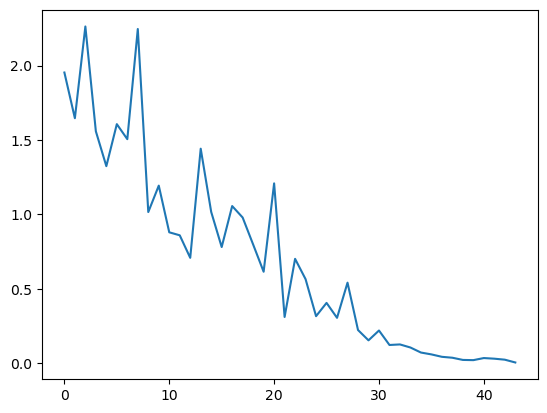

In [37]:
# Plot the model loss function
plt.plot(np.array(losses)[:,1])

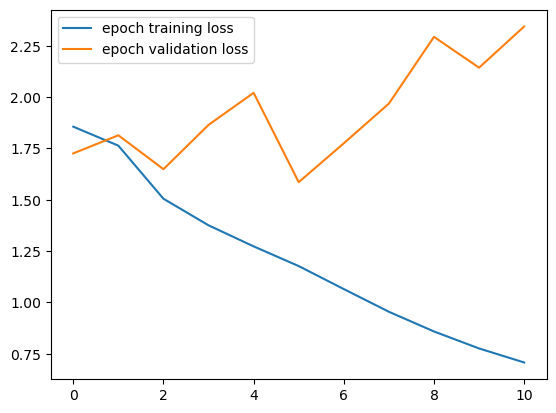

In [38]:
# Epoch training loss
plt.plot(epoch_losses, label='epoch training loss')
plt.plot(val_losses, label='epoch validation loss')
plt.legend()
plt.show()

In [39]:
os.getcwd()

'/home/jovyan'

In [ ]:
# Save the model

# results directory
save_dir = os.path.join(maindir,'results/resnet18/')
roi = 'dc'

save_res = True
if save_res:

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    step = len(losses)
    model_path = f'{roi}_planet_ms_ws{params['window_size']}_bs{params['batch_size']}_lr{params['learning_rate']}_ep{num_epochs}_step{step}.pt'
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'step': step,
        }, str(model_path))

    save(model_path)

In [ ]:
np.savetxt(os.path.join(save_dir, 'losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(losses))
np.savetxt(os.path.join(save_dir, 'epoch_loss_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(epoch_loss))
np.savetxt(os.path.join(save_dir, 'val_losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(val_losses))

In [40]:
import gc

def get_prediction(m, s):
    s = s.to(device)  # Ensure the sample is moved to the correct device
    res = m(s)
    return res

true_labels = []
pred_labels = []

model.eval()  # Set model to evaluation mode

for idx, sample in enumerate(test_ds):
    try:
        if sample['code'] != 255:
            # Append true labels
            true_labels.append(sample['code'].item())  # Convert tensor to Python scalar
                        
            # Get prediction and append
            pred = get_prediction(model, sample['image'][None, ...].float().to(device))  # Ensure tensor is float and on the correct device
            pred_labels.append(pred.argmax().item())  # Convert tensor to Python scalar
            
        else:
            print(f'sample {idx} of {len(test_ds)} had class label 255, skipping...')
        
        if idx % 100 == 0:
            time.sleep(0.3)
            gc.collect()
            print(f'Processed {idx} samples...')
        
    except Exception as e:
        print(f'Error at sample {idx}: {e}, continuing...')

Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...


In [41]:
# Ensure 'class_code' is of categorical dtype
test_df['code'] = test_df['code'].astype('category')

# Create the dictionary mapping
cat_dict = dict(enumerate(test_df['code'].cat.categories))
print(cat_dict)

# Filter the class codes present in the test set
class_codes_numbers = [k for k in cat_dict.keys() if cat_dict[k] in test_df['code'].unique().tolist()]

cor_labels = [cat_dict[c] for c in class_codes_numbers]
print(cor_labels)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
[0, 1, 2, 3, 4, 5, 6]


(array([140., 140.,   0., 140.,   0.,  23.,  21.,   0.,  29.,  14.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

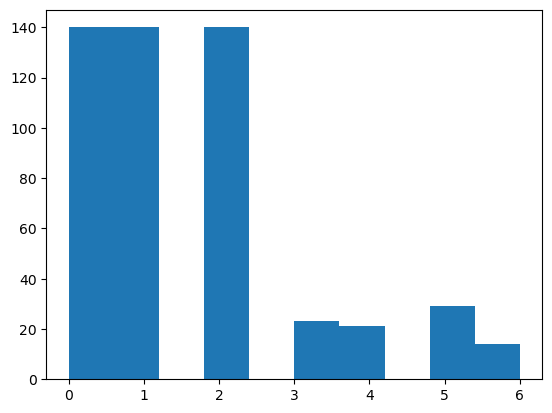

In [42]:
plt.hist(true_labels)

In [43]:
sum(p.numel() for p in model.parameters() if p.requires_grad) # number of trainable model parameters

11189511

In [44]:
# Generate the classification report
cr_df = pd.DataFrame(classification_report(true_labels, pred_labels, target_names=cor_labels, output_dict=True)).transpose()
print(cr_df)

              precision    recall  f1-score     support
0              0.681481  0.657143  0.669091  140.000000
1              0.834437  0.900000  0.865979  140.000000
2              0.641026  0.714286  0.675676  140.000000
3              0.684211  0.565217  0.619048   23.000000
4              0.833333  0.476190  0.606061   21.000000
5              0.680000  0.586207  0.629630   29.000000
6              0.555556  0.357143  0.434783   14.000000
accuracy       0.715976  0.715976  0.715976    0.715976
macro avg      0.701435  0.608027  0.642895  507.000000
weighted avg   0.715398  0.715976  0.711669  507.000000


In [45]:
for c in cor_labels:
    print(test_df.loc[test_df['code'] == c].shape[0])

140
140
140
23
21
29
14


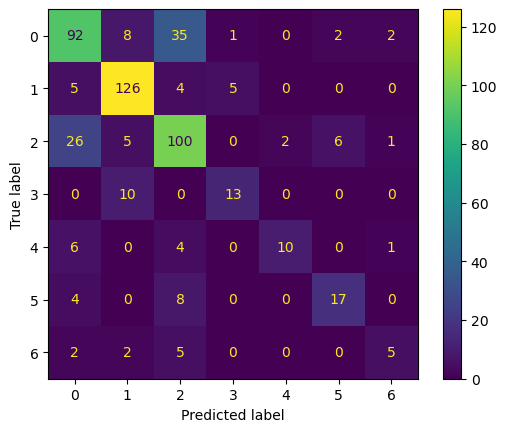

In [46]:
class_label_names = cor_labels # get these smartly somehow... categories got a bit mixed up
class_labels = class_codes_numbers
cm = confusion_matrix(true_labels, pred_labels, labels=cor_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cor_labels)
disp.plot()